In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import operator
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [2]:
def _euclidean_dist(p, q):
    return np.sqrt(np.power(p - q, 2).sum())


def _eps_reachable(p, q, eps):
    return _euclidean_dist(p, q) < eps


def _eps_neighborhood(data, point_id, eps):
    neighborhood = []
    rdist = []
    point = data[point_id]
    for q in range(len(data)):
        dist = _euclidean_dist(point, data[q])
        if dist < eps:
            neighborhood.append((q, dist))
    neighborhood = np.array(neighborhood, dtype=[('id', 'i'), ('dist', 'f')])
    neighborhood = np.delete(neighborhood, np.where(neighborhood['id'] == point_id))
    return neighborhood


def _is_core_object(neighborhood, minpts):
    if len(neighborhood) >= minpts:
        return True
    else:
        return False


def _update_order_seeds(neighborhood, minpts, reach_dists, processed, seeds):
    if not _is_core_object(neighborhood, minpts):
        return seeds
    core_dist = np.sort(neighborhood['dist'])[minpts - 2]
    for obj in neighborhood['id']:
        if not processed[obj]:
            obj_dist = neighborhood[neighborhood['id'] == obj]['dist'][0]
            newRdist = max(core_dist, obj_dist)
            if np.isnan(reach_dists[obj]):
                reach_dists[obj] = newRdist
                seeds[obj] = newRdist
            elif newRdist < reach_dists[obj]:
                reach_dists[obj] = newRdist
                seeds[obj] = newRdist
    return seeds


def optics(data, eps, minpts):
    processed = np.array([False] * len(data))
    core_dists = np.full(len(data), np.nan)
    reach_dists = np.full(len(data), np.nan)
    ordered_res = []
    seeds = {}
    for p_id in range(len(data)):
        if not processed[p_id]:
            ordered_res.append(p_id)
            processed[p_id] = True
            neighbors = _eps_neighborhood(data, p_id, eps)
            if _is_core_object(neighbors, minpts):
                core_dists[p_id] = np.sort(neighbors['dist'])[minpts - 2]
            seeds = _update_order_seeds(neighbors, minpts, reach_dists, processed, seeds)
            while len(seeds) > 0:
                nextId = sorted(seeds.items(), key=operator.itemgetter(1))[0][0]
                del seeds[nextId]
                processed[nextId] = True
                ordered_res.append(nextId)
                newNeighbors = _eps_neighborhood(data, nextId, eps)
                if _is_core_object(newNeighbors, minpts):
                    core_dists[nextId] = np.sort(newNeighbors['dist'])[minpts - 2]
                    seeds = _update_order_seeds(newNeighbors, minpts, reach_dists, processed, seeds)
    # 这里只是我的一个操作，强迫症看不惯有个nan存在。
    reach_dists[ordered_res[0]] = core_dists[ordered_res[0]]
    return ordered_res, reach_dists, core_dists


def cluster_optics_dbscan(data, eps_reachable, eps, minpts):
    orders, reach_dists, core_dists = optics(data, eps, minpts)
    n_samples = len(data)
    labels = np.zeros(n_samples, dtype=int)
    far_reach = reach_dists > eps_reachable
    near_core = core_dists <= eps_reachable
    labels[orders] = np.cumsum(far_reach[orders] & near_core[orders])
    labels[far_reach & ~near_core] = -1
    return labels, orders, reach_dists, core_dists

Estimated number of clusters: 3
Estimated number of noise points: 154
Homogeneity: 0.680
Completeness: 0.980
V-measure: 0.803
Adjusted Rand Index: 0.564
Adjusted Mutual Information: 0.679
Silhouette Coefficient: 0.704


/home/samael/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


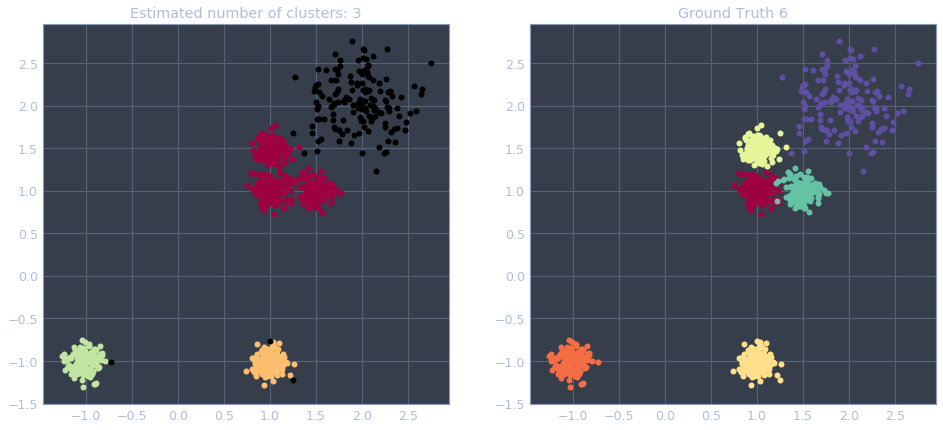

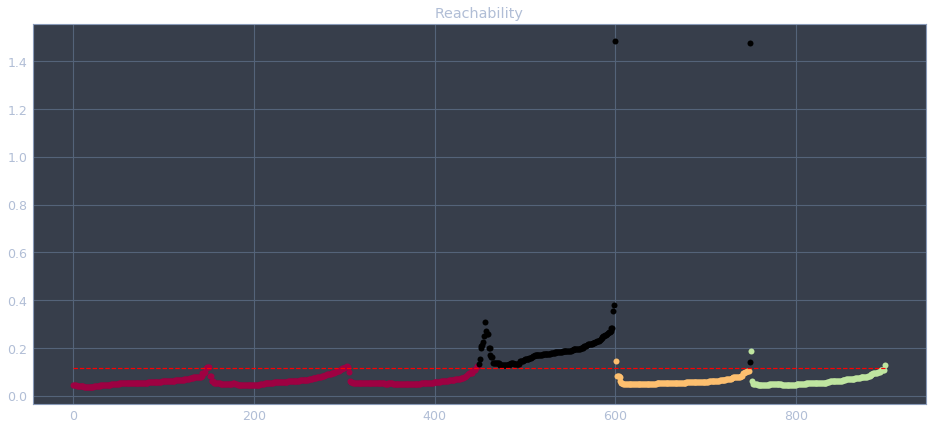

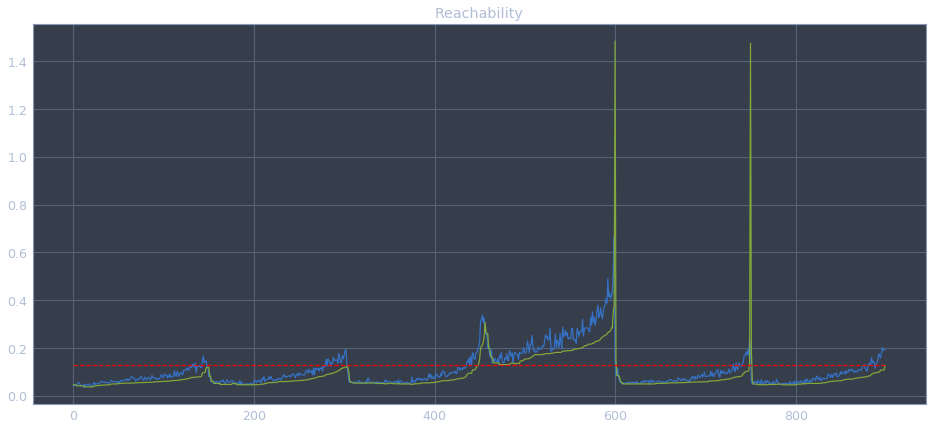

In [3]:
centers = [[1, 1], [-1, -1], [1, -1], [1, 1.5], [1.5, 1], [2, 2]]
X, labels_true = make_blobs(n_samples=900, centers=centers, cluster_std=[0.1] * 5 + [0.3],
                            random_state=0)

labels, orders, reach_dists, core_dists = cluster_optics_dbscan(
    X, 0.13, np.inf, 20)
core_samples_mask = np.zeros_like(labels, dtype=bool)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result

# Black removed and is used for noise instead.
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.subplot(1, 2, 2)
unique_labels = set(labels_true)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels_true == k)

    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
plt.title('Ground Truth %d' % len(unique_labels))

plt.figure(figsize=(16, 7))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    ordered_labels = labels[orders]
    class_member_mask = (ordered_labels == k)
    space = np.arange(len(X))
    ordered_rdists = reach_dists[orders]
    ordered_cdists = core_dists[orders]
    xy = X[class_member_mask]
    # plt.plot(space[class_member_mask], ordered_cdists[class_member_mask])
    plt.plot(space[class_member_mask], ordered_rdists[class_member_mask],
             'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)
plt.plot(np.arange(len(X)), [0.115] * len(X), '--', color='red')
plt.title('Reachability')

plt.figure(figsize=(16, 7))
plt.plot(np.arange(len(X)), core_dists[orders])
plt.plot(np.arange(len(X)), reach_dists[orders])
plt.plot(np.arange(len(X)), [0.13] * len(X), '--', color='red')
plt.title('Reachability')

plt.show()